* THE DATASET https://github.com/Jakobovski/free-spoken-digit-dataset/tree/master
* https://docs.activeloop.ai/ Doesn't work
* https://github.com/eonu/torch-fsdd crazy implementation



In [1]:
%%shell
pip install -q sktime

# --- ENGLISH ---
# Remove master.zip and download it from free-spoken-digit-dataset github.
rm -f master.zip
wget . https://github.com/Jakobovski/free-spoken-digit-dataset/archive/refs/heads/master.zip
# Remove free-spoken-digit-dataset-master and unzip it from master.zip
rm -rf free-spoken-digit-dataset-master
unzip master.zip > /dev/null

# --- ARABIC ---
# Remove SpokenArabicDigits* download it from timeseriesclassification.com and unzip it.
rm -rvf SpokenArabicDigits*
wget . http://www.timeseriesclassification.com/Downloads/SpokenArabicDigits.zip
unzip SpokenArabicDigits.zip > /dev/null

--2023-06-05 18:19:56--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
--2023-06-05 18:19:56--  https://github.com/Jakobovski/free-spoken-digit-dataset/archive/refs/heads/master.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/Jakobovski/free-spoken-digit-dataset/zip/refs/heads/master [following]
--2023-06-05 18:19:56--  https://codeload.github.com/Jakobovski/free-spoken-digit-dataset/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.113.10
Connecting to codeload.github.com (codeload.github.com)|140.82.113.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [      <=>           ]  15.66M  13.8MB/s    in 1.1s    

2023-06-0

In [2]:
# Imports
import IPython.display as ipd
from IPython.display import Audio, display
import librosa
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from scipy import signal
import torch
from torch import nn
from torch.utils.data import TensorDataset
import torchaudio
from torch.utils.data import Dataset, DataLoader
import numpy as np
from functools import partial

from librosa.effects import (preemphasis, deemphasis,)
from tqdm.auto import tqdm

from torch.nn.utils.rnn import pad_sequence
from collections import namedtuple

from sktime.datasets import load_from_tsfile

In [3]:
# Helper functions
SAMPLING_RATE_HZ = 8000
WINDOW = signal.windows.hamming

first = lambda iterable: next(iter(iterable))

def show_audio(audio):
    plt.close()
    plt.figure()
    plt.title("audio")
    plt.plot(audio)
    plt.show()

play_audio = lambda a: ipd.Audio(a, rate=SAMPLING_RATE_HZ)

show_and_play = lambda a: show_audio(a) or play_audio(a)

load_audio = lambda a: librosa.load(a, sr=SAMPLING_RATE_HZ)[0]

audio_to_mfcc = lambda a: librosa.feature.mfcc(y=a,
                                               sr=SAMPLING_RATE_HZ,
                                               window=WINDOW,
                                               n_mfcc=13,
                                              )

mfcc_to_audio = lambda m: librosa.feature.inverse.mfcc_to_audio(m,
                                                    sr=SAMPLING_RATE_HZ,
                                                    window=WINDOW,
                                                   )

def tensor_from_iterable_of_arrays(feat, transpose=True, max_len=None):
    var_len_idx = 1 if transpose else 0
    if max_len is None:
        max_len = max(r.shape[var_len_idx] for r in feat)
    a = np.zeros((len(feat), max_len, 13))

    # Left-padding
    for i, m in enumerate(feat):
        a[i, (max_len - m.shape[var_len_idx]):, :] = m.T if transpose else m

    # Check
    print('Check the padded subset equals the original')
    display(
        all(
            np.allclose(
                (a[idx, max_len-feat[idx].shape[var_len_idx]:, :].T
                 if transpose
                 else a[idx, max_len-feat[idx].shape[var_len_idx]:, :]),
                        feat[idx])
            for idx in range(a.shape[0])
        )
    )

    features = torch.tensor(a, dtype=torch.float32)
    features.shape
    return features

In [4]:
# Choose device cuda or cpu
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

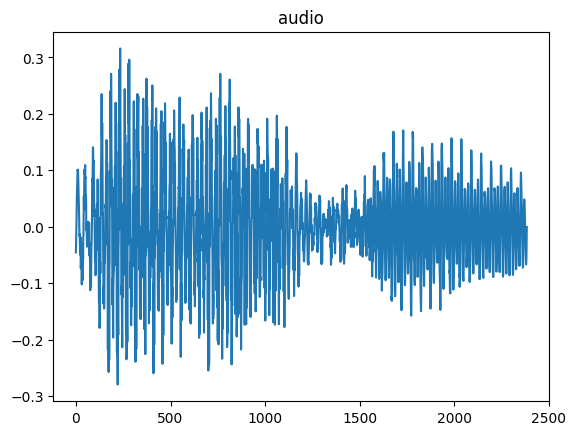

In [5]:
# First look at the enlish data.
example_path = first(
    sorted(
        Path('./free-spoken-digit-dataset-master/recordings').glob('*.wav')
    )
)

example_audio = load_audio(example_path)
show_and_play(example_audio)

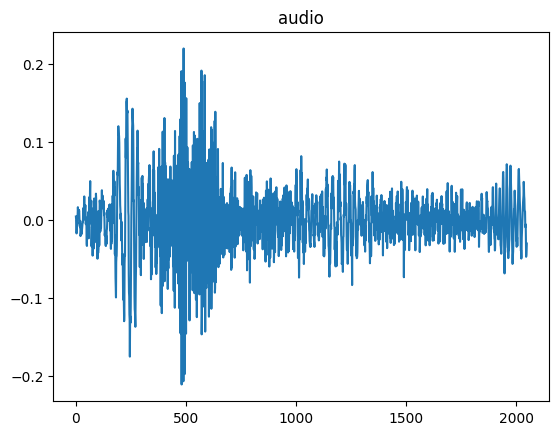

In [6]:
# Sound recostruction from MFCC coefficients
show_and_play(mfcc_to_audio(audio_to_mfcc(example_audio)))

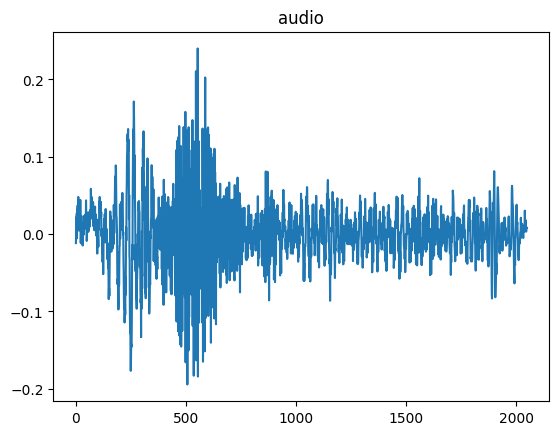

In [7]:
# With the preemphassis and deemphasis, as there are no transmission noises
# the sound should be very close to equal of the preivous one.
show_and_play(
    deemphasis(
        mfcc_to_audio(
            audio_to_mfcc(
                preemphasis(
                    example_audio
                )
            )
        )
    )
)

In [8]:
# Load the enlish data and do basic preprocessing
FEAT, TARG, SPEAKER, PATH = zip(*[(audio_to_mfcc(preemphasis(load_audio(path))),
        int((target_speaker_attempt := path.stem.split('_'))[0]),
        target_speaker_attempt[1],
        str(path),
       )
    for path in tqdm(
        sorted(
            Path('./free-spoken-digit-dataset-master/recordings').glob('*.wav')))
]
)

  0%|          | 0/3000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1933
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1399
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1876
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1983
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2033
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1963
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py

In [9]:
# Load the arabic data and do the basic preprocesisng
feat_train_arabic, targ_train_arabic = load_from_tsfile('SpokenArabicDigits_TRAIN.ts')
feat_test_arabic, targ_test_arabic = load_from_tsfile('SpokenArabicDigits_TEST.ts')

feat_train_arabic_iterable = [
    pd.concat([x for x in feat_train_arabic.iloc[row, :]], axis=1).to_numpy()
    for row in tqdm(range(feat_train_arabic.shape[0]))
]
feat_test_arabic_iterable = [
    pd.concat([x for x in feat_test_arabic.iloc[row, :]], axis=1).to_numpy()
    for row in tqdm(range(feat_test_arabic.shape[0]))
]

  0%|          | 0/6599 [00:00<?, ?it/s]

  0%|          | 0/2199 [00:00<?, ?it/s]

In [10]:
# ENGLISH
# Creates tensor "features" with shape (samples,seq_len,mfcc_features)
features = tensor_from_iterable_of_arrays(FEAT, transpose=True)

# Creates "targets" tensor
targets = torch.tensor(TARG)
display(targets.shape)

# Creates tensor indicating speakers by speaker nubmers
# using helper mapping from speaker name to number
name_to_num = {name: num for num, name in enumerate(sorted(set(SPEAKER)))}

speakers = torch.tensor([name_to_num[name] for name in SPEAKER])

display(name_to_num, speakers)

Check the padded subset equals the original


True

torch.Size([3000])

{'george': 0, 'jackson': 1, 'lucas': 2, 'nicolas': 3, 'theo': 4, 'yweweler': 5}

tensor([0, 0, 0,  ..., 5, 5, 5])

In [11]:
# ARABIC
features_train_arabic = tensor_from_iterable_of_arrays(
    feat_train_arabic_iterable, transpose=False)

features_test_arabic = tensor_from_iterable_of_arrays(
    feat_test_arabic_iterable, transpose=False, max_len=93)

display(
    features_train_arabic.shape,
    features_test_arabic.shape
)

targets_train_arabic = torch.tensor([int(i) if i != '10' else 0
                                     for i in targ_train_arabic])
targets_test_arabic = torch.tensor([int(i) if i != '10' else 0
                                    for i in targ_test_arabic])

display(
    targets_train_arabic.shape,
    targets_test_arabic.shape
)

Check the padded subset equals the original


True

Check the padded subset equals the original


True

torch.Size([6599, 93, 13])

torch.Size([2199, 93, 13])

torch.Size([6599])

torch.Size([2199])

In [12]:
# ENLISH - from features and targets to Dataloaders
# Choose speakers for the "trian", "val" and "test" data.
if (RANDOM := False):
    perms = np.random.permutation(list(name_to_num.values()))
    train, val, test = perms[:3], perms[3:5], perms[5:]
else:
    train, val, test = ([1, 3, 4], [0, 2], [5])

print(
    f'train: {train}',
    f'val:   {val}',
    f'test:  {test}',
    sep='\n',
)

test_idx = sum(speakers == i for i in test).nonzero().squeeze()
val_idx = sum(speakers == i for i in val).nonzero().squeeze()
train_idx = sum(speakers == i for i in train).nonzero().squeeze()

display(
    train_idx.shape, val_idx.shape, test_idx.shape
)

train_ds = TensorDataset(features[train_idx], targets[train_idx])
val_ds = TensorDataset(features[val_idx], targets[val_idx])
test_ds = TensorDataset(features[test_idx], targets[test_idx])

TRAIN_ENGLISH_LOADER = DataLoader(train_ds, batch_size=32, shuffle=True)
VAL_ENGLISH_LOADER = DataLoader(val_ds, batch_size=32, shuffle=True)
TEST_ENGLISH_LOADER = DataLoader(test_ds, batch_size=32, shuffle=True)

train: [1, 3, 4]
val:   [0, 2]
test:  [5]


torch.Size([1500])

torch.Size([1000])

torch.Size([500])

In [13]:
# ARABIC - from features and targets to Dataloaders
generator = torch.Generator().manual_seed(42)
train_arabic_ds, val_arabic_ds = torch.utils.data.random_split(
    TensorDataset(features_train_arabic, targets_train_arabic),
    [0.7, 0.3], generator=generator
)
test_arabic_ds = TensorDataset(features_test_arabic, targets_test_arabic)

TRAIN_ARABIC_LOADER = DataLoader(train_arabic_ds, batch_size=32, shuffle=True)
VAL_ARABIC_LOADER = DataLoader(val_arabic_ds, batch_size=32, shuffle=True)
TEST_ARABIC_LOADER = DataLoader(test_arabic_ds, batch_size=32, shuffle=True)

In [14]:
# IMPORTANT!
# Chose enlish or arabic dataloaders by commenting one of the lines.

(TRAIN_LOADER,
 VAL_LOADER,
 TEST_LOADER) =  (
      TRAIN_ENGLISH_LOADER, VAL_ENGLISH_LOADER, TEST_ENGLISH_LOADER,
      # TRAIN_ARABIC_LOADER, VAL_ARABIC_LOADER, TEST_ARABIC_LOADER,
)

In [15]:
# Look at the data from dataloader
feat_example, targ_example = next(iter(TRAIN_LOADER))
feat_example.shape, targ_example.shape

(torch.Size([32, 36, 13]), torch.Size([32]))

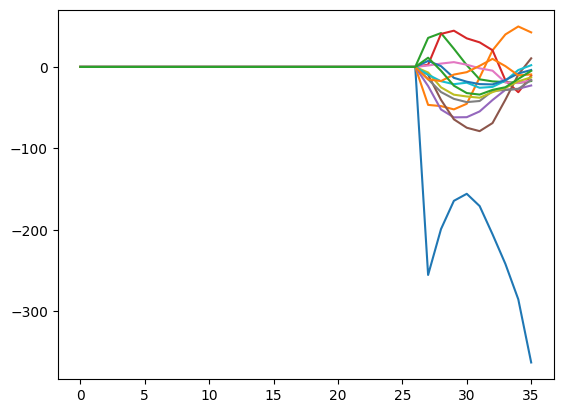

In [16]:
# Plot of the features
plt.plot(feat_example[0])

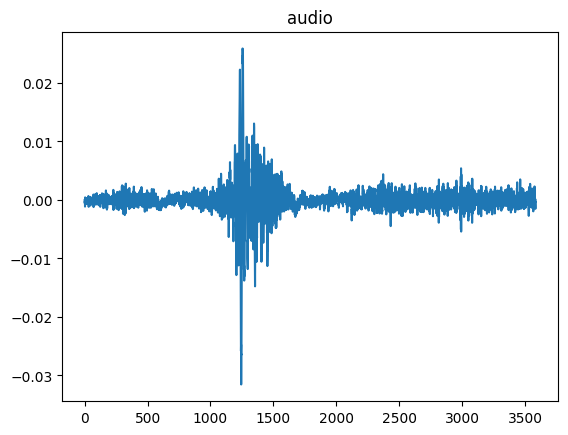

In [17]:
# Example converted to sound (check if human could classify it).
EXAMPLE_IDX = 15 # 0-31
show_and_play(
    deemphasis(
        mfcc_to_audio(
            (arr :=  feat_example[EXAMPLE_IDX].numpy().T)[:, (arr == 0).argmin():]
        )
    )
)

In [18]:
# Correct target
targ_example[EXAMPLE_IDX]

tensor(6)

In [19]:
# Helper functions for training
Stats = namedtuple('Stats', ['train_loss', 'train_metric', 'val_loss', 'val_metric'])

def train_and_validate(model, optimizer,
                       train_loader,
                       validation_loader,
                       loss_fn=nn.CrossEntropyLoss(),
                       metric_fn=lambda o,t: (o.argmax(axis=1)==t).sum().item(),
                      ):
    train_loss, train_metric, val_loss, val_metric = 0, 0, 0, 0

    # Training
    model.train(True)
    for feat_train, targ_train in train_loader:
        optimizer.zero_grad()
        out_train = model(feat_train.to(DEVICE))
        targ_train = targ_train.to(DEVICE)
        loss = loss_fn(out_train, targ_train)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_metric += metric_fn(out_train.detach(), targ_train)

    # Validation
    model.eval()
    with torch.no_grad():
        for feat_val, targ_val in validation_loader:
            out_val = model(feat_val.to(DEVICE)).detach()
            targ_val = targ_val.to(DEVICE)
            val_loss += loss_fn(out_val, targ_val).item()
            val_metric += metric_fn(out_val, targ_val)

    return Stats(
        train_loss / (train_cnt := len(train_loader.dataset)),
        train_metric / train_cnt,
        val_loss / (val_cnt := len(validation_loader.dataset)),
        val_metric / val_cnt,
    )

def show_stats(stats, title):
    arr = np.array(stats)

    fig, axes = plt.subplots(1, 2, figsize=(8, 4), layout='constrained')
    axes[0].plot(arr[:, [0, 2]])
    axes[0].set_title('Loss (best: train={:.3}, val={:.3})'
                      .format(*arr[:, [0, 2]].min(axis=0)))

    axes[1].plot(arr[:, [1, 3]])
    axes[1].set_title('Metric (best: train={:.3}, val={:.3})'
                      .format(*arr[:, [1, 3]].max(axis=0)))
    fig.legend(['train', 'validation'],  bbox_to_anchor=(0.23, 0.21))#loc='lower right',
    fig.suptitle(title)
    plt.show()

In [20]:
# Models, config, and choice of a model.
FEATURE_CNT = 13
CLASS_CNT = 10

class RNN(nn.Module):
    def __init__(self, feature_cnt, class_cnt, rec_layers, drop_prob, **unused):
        super(RNN, self).__init__()
        self.hidden_size=64
        self.num_layers=rec_layers

        self.rnn = nn.RNN(input_size=feature_cnt,
                          hidden_size=self.hidden_size,
                          num_layers=self.num_layers,
                          batch_first=True,
                          dropout=drop_prob,
                          )
        self.gelu1 = nn.GELU()
        self.drop1 = nn.Dropout(p=drop_prob)
        self.fc1 = nn.Linear(self.hidden_size, 32)
        self.gelu = nn.GELU()
        self.drop = nn.Dropout(p=drop_prob)
        self.fc = nn.Linear(32, class_cnt)
        # self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        #               (1*num_layers,    batch_size, hidden_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(DEVICE) 
        # ((batch_size, seq_length, hidden_size), ...)
        output, hn = self.rnn(x, h0)
        #      batch, last_seq, hidden_size
        return self.fc(
            self.drop(
                self.gelu(
                    self.fc1(
                        self.drop1(
                            self.gelu1(
                                output[:, -1, :]
                            )
                        )
                    )
                )
            )
        )

class LSTM(nn.Module):
    def __init__(self, rec_layers, drop_prob, **unused):
        super(LSTM, self).__init__()
        self.hidden_size=32
        self.num_layers=rec_layers

        self.lstm = nn.LSTM(input_size=FEATURE_CNT,
                            hidden_size=self.hidden_size,
                            num_layers=self.num_layers,
                            batch_first=True,
                            dropout=drop_prob,
                            )
        self.drop = nn.Dropout(p=drop_prob)
        self.fc = nn.Linear(self.hidden_size, CLASS_CNT)
    
    def forward(self, x):
        # lstm input shapes: ((batch_size, seq_length, hidden_size), (h, c))
        #                     If (h, c) is not given, zero vectors are used.
        output, (h, c) = self.lstm(x)
        # (batch, last_seq, hidden_size), (h, c) - lstm output shapes.
        return self.fc(
            self.drop(
                output[:, -1, :]
            )
        )


# Instantiate the model
config = dict(
    feature_cnt=FEATURE_CNT,
    class_cnt=CLASS_CNT,
    rec_layers=2,
    lin_layers=2, # DOES NOT WORK - lin layers are so far hard coded.
    drop_prob=0.2,
    lr = 0.001,
    weight_decay=0.01,
)

# IMPORTANT!
# Choose one of the model, by commenting out exaclty one out of two following lines.
model = RNN(**config).to(DEVICE)
# model = LSTM(**config).to(DEVICE)

optim_class = torch.optim.Adam
# optim_class = torch.optim.SGD
# optim_class = torch.optim.AdamW

optimizer = optim_class(model.parameters(),
                        lr=config['lr'],
                        weight_decay=config['weight_decay'],
                        )

param_cnt = sum(p.numel() for p in model.parameters())

MODEL_NAME = '--'.join([
    str(model).split('(')[0], # name
    f"rec-{config['rec_layers']}",
    f"dp-{config['drop_prob']}",
    f"lin-{config['lin_layers']}",
    f"par-{param_cnt}",
    f"opt-{(str(optimizer).split()[0])}",
    f"lr-{config['lr']}",
    f"wd-{config['weight_decay']}",
]).lower()

print(MODEL_NAME)
display(model)
display(optimizer)

best_train_metric, best_val_metric = -1, -1
stats = []
epoch = 0
epoch_cnt = 1000

rnn--rec-2--dp-0.2--lin-2--par-15786--opt-adam--lr-0.001--wd-0.01


RNN(
  (rnn): RNN(13, 64, num_layers=2, batch_first=True, dropout=0.2)
  (gelu1): GELU(approximate='none')
  (drop1): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (gelu): GELU(approximate='none')
  (drop): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=32, out_features=10, bias=True)
)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.01
)

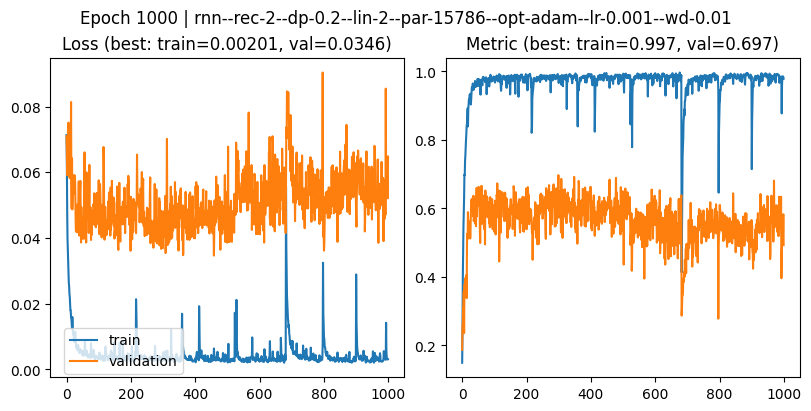

Stats(train_loss=0.0031136590217550595, train_metric=0.9786666666666667, val_loss=0.06478640520572662, val_metric=0.493)


In [21]:
# The training loop.
for epoch in range(epoch+1, epoch+epoch_cnt+1):
    stats.append(train_and_validate(model, optimizer,
                                    train_loader=TRAIN_LOADER,
                                    validation_loader=VAL_LOADER
                                    ))
    print(stats[-1])

    if (train_metric := stats[-1].train_metric) >= best_train_metric:
        best_train_metric = train_metric 

    if (val_metric := stats[-1].val_metric) >= best_val_metric:
        torch.save(model.state_dict(), MODEL_NAME)
        best_val_metric = val_metric

    if epoch % 10 == 0:
        ipd.clear_output(wait=True)
        show_stats(stats, f'Epoch {epoch} | {MODEL_NAME}')
else:
    print(stats[-1])

In [26]:
display(MODEL_NAME)

'rnn--rec-2--dp-0.2--lin-2--par-15786--opt-adam--lr-0.001--wd-0.01'

In [23]:
# Load the best model found based on validation metric.
model = RNN(**config).to(DEVICE)
model.load_state_dict(torch.load(MODEL_NAME))
model.eval()

RNN(
  (rnn): RNN(13, 64, num_layers=2, batch_first=True, dropout=0.2)
  (gelu1): GELU(approximate='none')
  (drop1): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (gelu): GELU(approximate='none')
  (drop): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=32, out_features=10, bias=True)
)

In [24]:
# Check the Test loss and accuracy
# (this should be run only and exactly once).
loss_fn=nn.CrossEntropyLoss()
metric_fn=lambda o,t: (o.argmax(axis=1)==t).sum().item()

test_loss, test_metric = 0, 0
model.eval()
with torch.no_grad():
    for feat_test, targ_test in TEST_LOADER:
        out_test = model(feat_test.to(DEVICE)).detach()
        targ_test = targ_test.to(DEVICE)
        test_loss += loss_fn(out_test, targ_test).item()
        test_metric += metric_fn(out_test, targ_test)

print("Test Loss:", test_loss / (test_cnt := len(TEST_LOADER.dataset)),
      "test accuracy:", test_metric / test_cnt,
      )

Test Loss: 0.021148604184389113 test accuracy: 0.808


In [25]:
! pip freeze

absl-py==1.4.0
alabaster==0.7.13
albumentations==1.2.1
altair==4.2.2
anyio==3.6.2
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
array-record==0.2.0
arviz==0.15.1
astropy==5.2.2
astunparse==1.6.3
attrs==23.1.0
audioread==3.0.0
autograd==1.5
Babel==2.12.1
backcall==0.2.0
beautifulsoup4==4.11.2
bleach==6.0.0
blis==0.7.9
blosc2==2.0.0
bokeh==2.4.3
branca==0.6.0
build==0.10.0
CacheControl==0.12.11
cached-property==1.5.2
cachetools==5.3.0
catalogue==2.0.8
certifi==2022.12.7
cffi==1.15.1
chardet==4.0.0
charset-normalizer==2.0.12
chex==0.1.7
click==8.1.3
cloudpickle==2.2.1
cmake==3.25.2
cmdstanpy==1.1.0
colorcet==3.0.1
colorlover==0.3.0
community==1.0.0b1
confection==0.0.4
cons==0.4.5
contextlib2==0.6.0.post1
contourpy==1.0.7
convertdate==2.4.0
cryptography==40.0.2
cufflinks==0.17.3
cupy-cuda11x==11.0.0
cvxopt==1.3.0
cvxpy==1.3.1
cycler==0.11.0
cymem==2.0.7
Cython==0.29.34
dask==2022.12.1
datascience==0.17.6
db-dtypes==1.1.1
dbus-python==1.2.16
debugpy==1.6.6
decorator==4.4.2